In [1]:
import os
# Change native directory to root
os.chdir(os.path.dirname(os.getcwd()))

In [2]:
import glob
import pandas as pd
import numpy as np
import random
import pickle
import matplotlib.pyplot as plt
import plotly.express as px

# K-mean clustering libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

from tqdm import tqdm

random.seed(123)
model_dir = 'models/'

In [3]:
# Read the features from the csv file
features = pd.read_csv('data/social_features.csv', index_col=0)
# read metadata csv
metadata = pd.read_csv('data/EANLIJST_METADATA.csv', index_col=0, sep   = ';')
# ADD the functietype column to the features
features['function'] = metadata['Patrimonium Functietype']
# read more metrics from csv
features.isnull().sum()
features.dropna(inplace=True)
features['ID'] = features.index
# drop rows with kast as function
features = features[features['function'] != 'Kast']
features['morning'] = features.iloc[:,4:16].sum(axis=1)
features['evening'] = features.iloc[:,np.r_[:4,16:24]].sum(axis=1)
features['weekday'] = features.iloc[:,24:29].sum(axis=1)
features['weekend'] = features.iloc[:,29:31].sum(axis=1)
# scale yearly column to 0-1 with minmax scaler
ds = features[['yearly', 'weekend',  'evening']].copy()
ds['yearly'] = MinMaxScaler().fit_transform(ds['yearly'].values.reshape(-1,1))
ds

,yearly,weekend,evening
1208,0.043184,0.237764,0.426774
588,0.023923,0.263603,0.548167
1116,0.004459,0.446731,0.566519
144,0.021442,0.105142,0.272579
510,0.004152,0.238654,0.457893
...,...,...,...
56,0.017418,0.276985,0.438050
13,0.047746,0.203067,0.417403
1660,0.039817,0.270733,0.470136
235,0.024982,0.161183,0.355166


In [23]:
clust_num = 10
# K-mean clustering on the features dataset
kmeans = KMeans(n_clusters=clust_num, random_state=2).fit(ds)
# kmeans save model
pickle.dump(kmeans, open(model_dir+"kmeans{}.pkl".format(clust_num), "wb"))
clusters = kmeans.labels_
features['cluster'] = clusters

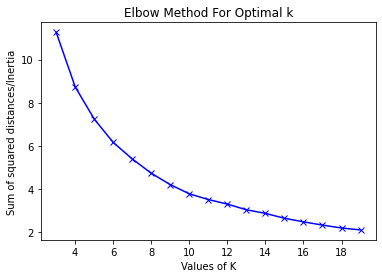

In [13]:
Sum_of_squared_distances = []
K = range(3, 20)
for clust_num in K:
    kmeans = KMeans(n_clusters=clust_num, random_state=2).fit(ds)
    Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K,Sum_of_squared_distances,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

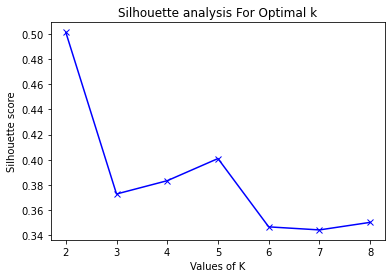

In [14]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
silhouette_avg = []
for num_clusters in range_n_clusters:
    # initialise kmeans
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(ds)
    cluster_labels = kmeans.labels_
    # silhouette score
    silhouette_avg.append(silhouette_score(ds, cluster_labels))
plt.plot(range_n_clusters,silhouette_avg,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()

In [24]:
fig = px.scatter(features, x='evening', y='weekend', color='cluster', hover_name=features.function, hover_data=features[['ID']])
# make the figure bigger
plt.figure(figsize=(100, 10))
fig.update_traces(mode="markers")   
fig.show()

<Figure size 7200x720 with 0 Axes>

In [27]:
schools = features.loc[features.function == 'Administratief centrum']
fig = px.scatter(schools, x='evening', y='weekend', color='cluster', hover_name=schools.function, hover_data=schools[['ID']])
# make the figure bigger
plt.figure(figsize=(100, 10))
# x axis scale
#plt.xlim([0])
fig.update_traces(mode="markers")   
fig.show()

<Figure size 7200x720 with 0 Axes>

In [25]:
# Show  value counts in the function column for each cluster
counts = features.groupby('cluster').function.value_counts().sort_values(ascending=False).unstack().T
counts.loc[counts.sum(axis=1).sort_values(ascending=False).index]

cluster,0,1,2,3,4,5,6,7,8,9
function,,,,,,,,,,
Sporthal,9.0,15.0,15.0,NaN,4.0,1.0,1.0,3.0,57.0,NaN
Andere gebouwen,4.0,9.0,13.0,NaN,7.0,24.0,NaN,5.0,29.0,2.0
Administratief centrum,11.0,45.0,2.0,1.0,9.0,2.0,5.0,NaN,7.0,NaN
Cultureel centrum,7.0,15.0,2.0,1.0,3.0,7.0,1.0,NaN,43.0,NaN
Ontmoetingscentrum,1.0,14.0,2.0,NaN,1.0,19.0,2.0,NaN,26.0,NaN
Lagere school,NaN,17.0,NaN,NaN,36.0,NaN,NaN,NaN,2.0,NaN
RVT/WZC/revalidatiecentrum,20.0,2.0,1.0,NaN,NaN,NaN,13.0,NaN,3.0,NaN
Stadhuis/Gemeentehuis,6.0,23.0,NaN,NaN,3.0,NaN,1.0,NaN,5.0,NaN
Werkplaats,NaN,9.0,NaN,NaN,14.0,2.0,NaN,NaN,5.0,NaN


In [34]:
day_p = pd.DataFrame()
# Create stanard profiles for each cluster
for k, clust in enumerate(range(clust_num)):
    agg = pd.DataFrame()
    for i, ID in enumerate(features[features.cluster == clust].index):
        #print(ID)
        agg[ID] = pd.read_csv('./data/buildings/' + str(ID) + '.csv', index_col=0, usecols=['ds','Power'], parse_dates=['ds'])
        agg[ID] = agg[ID] / agg.loc['2019'][ID].sum()
    # drop the rows with any infinite values
    agg = agg[~np.isinf(agg).any(1)]
    # Create an average profile over columns
    agg = agg.mean(axis=1)
    # group by hour of the day and make an average
    agg = agg.groupby(agg.index.hour).mean()
    day_p[clust] = agg

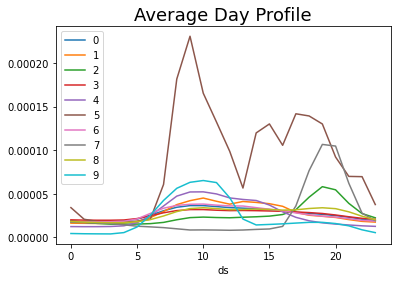

In [36]:
#day_p.columns = ['Cluster 0', 'Cluster 1','Cluster 2','Cluster 3', 'Cluster 4']
day_p.plot()
plt.title('Average Day Profile', fontsize=18)
plt.show()

In [46]:
weekly_p = pd.DataFrame()
# Create stanard profiles for each cluster
for k, clust in enumerate(range(clust_num)):
    for i, ID in enumerate(features[features.cluster == clust].index):
        #print(ID)
        if i == 0:
            agg = pd.read_csv('./data/buildings/' + str(ID) + '.csv', index_col=0, usecols=['ds','Power'], parse_dates=['ds'])
            agg = agg / 
            agg['2019'].sum()
        else:
            agg[ID] = pd.read_csv('./data/buildings/' + str(ID) + '.csv', index_col=0, usecols=['ds','Power'], parse_dates=['ds'])
            agg[ID] = agg[ID] / agg['2019'][ID].sum()
    # drop the rows with any infinite values
    agg = agg[~np.isinf(agg).any(1)]
    # Create an average profile over columns
    agg = agg.mean(axis=1)
    # group by day of the week and take and average
    agg = agg.groupby(agg.index.weekday).mean()

In [27]:
st_p = pd.DataFrame()
# Create stanard profiles for each cluster
for k, clust in enumerate(range(clust_num)):
    agg = pd.DataFrame()
    for i, ID in enumerate(features[features.cluster == clust].index):
        #print(ID)
        agg[ID] = pd.read_csv('./data/buildings/' + str(ID) + '.csv', index_col=0, usecols=['ds','Power'], parse_dates=['ds'])
        agg[ID] = agg[ID] / agg.loc['2019'][ID].sum()
    # Create an average profile over columns
    agg = agg.mean(axis=1)
    st_p[clust] = agg

In [29]:
for clust_num in [3,5,10,15,20]:
    # K-mean clustering on the features dataset
    kmeans = KMeans(n_clusters=clust_num, random_state=2).fit(ds)
    # kmeans save model
    pickle.dump(kmeans, open(model_dir+"kmeans{}.pkl".format(clust_num), "wb"))
    clusters = kmeans.labels_
    features['cluster'] = clusters
    st_p = pd.DataFrame()
    # Create stanard profiles for each cluster
    for k, clust in enumerate(range(clust_num)):
        agg = pd.DataFrame()
        for i, ID in enumerate(features[features.cluster == clust].index):
            #print(ID)
            agg[ID] = pd.read_csv('./data/buildings/' + str(ID) + '.csv', index_col=0, usecols=['ds','Power'], parse_dates=['ds'])
            agg[ID] = agg[ID] / agg.loc['2019'][ID].sum()
        # Create an average profile over columns
        agg = agg.mean(axis=1)
        st_p[clust] = agg
    st_p.to_csv('./data/st_p_kmeans'+str(clust_num)+'.csv')